# Example Notebook

In [1]:
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from statsmodels.nonparametric.kernel_regression import KernelReg

from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

from rdrobust import rdrobust

import doubleml as dml
from doubleml.rdd import RDFlex
from doubleml.rdd.datasets import make_simple_rdd_data

## Data

### Generate Data

In [2]:
np.random.seed(42)

fuzzy = True
data_dict = make_simple_rdd_data(n_obs=1000, fuzzy=fuzzy)

cov_names = ['x' + str(i) for i in range(data_dict['X'].shape[1])]
df = pd.DataFrame(
    np.column_stack((data_dict['Y'], data_dict['D'], data_dict['score'], data_dict['X'])),
    columns=['y', 'd', 'score'] + cov_names,
)
df

,y,d,score,x0,x1,x2
0,2.131533,1.0,0.496714,-0.665035,-0.790864,0.272860
1,10.104291,1.0,-0.138264,0.412951,-0.936828,0.872424
2,3.337677,1.0,0.647689,-0.896057,0.082593,0.418121
3,7.767124,1.0,1.523030,0.741938,0.428174,0.603456
4,4.209740,1.0,-0.234153,-0.321100,0.629650,-0.839770
...,...,...,...,...,...,...
995,3.081325,1.0,-0.281100,0.468731,-0.582338,-0.882869
996,4.170255,1.0,1.797687,0.104732,0.190459,0.743826
997,2.992416,1.0,0.640843,0.153963,-0.309038,0.606024
998,1.791844,1.0,-0.571179,0.080558,-0.841439,0.131701


In [3]:
fig = px.scatter(
    x=df['score'],
    y=df['y'],
    color=df['d'].astype(bool),
    labels={
        "x": "Score",   
        "y": "Outcome",
        "color": "Treatment"
    },
    title="Scatter Plot of Outcome vs. Score by Treatment Status"
)

fig.update_layout(
    xaxis_title="Score",
    yaxis_title="Outcome"
)
fig.show()

C:\Users\BAQ7040\AppData\Roaming\Python\Python311\site-packages\plotly\express\_core.py:1979: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


### Oracle Values and Comparisons

In [4]:
ite = data_dict['oracle_values']['Y1'] - data_dict['oracle_values']['Y0']
score = data_dict['score']

oracle_model = KernelReg(endog=ite, exog=score, reg_type='ll', var_type='c', ckertype='gaussian')

score_grid = np.linspace(-1, 1, 100)
oracle_effects, _ = oracle_model.fit(score_grid)


scatter = go.Scatter(
    x=score,
    y=ite,
    mode='markers',
    name='ITE',
    marker=dict(color='blue')
)
line = go.Scatter(
    x=score_grid,
    y=oracle_effects,
    mode='lines',
    name='Average Effect Estimate',
    line=dict(color='red')
)


fig = go.Figure(data=[scatter, line])
fig.update_layout(
    title='Locally Linear Kernel Regression of ITE on Score',
    xaxis_title='Score',
    yaxis_title='Effect',
    legend=dict(x=0.8, y=0.2)
)

fig.show()

## RDD with linear adjustment

In [5]:
rdrobust_linear = rdrobust(y=df['y'], x=df['score'], fuzzy=df['d'], covs=df[cov_names], c=0.0)
rdrobust_linear

Call: rdrobust
Number of Observations:                  1000
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           490        510
Number of Unique Obs.            490        510
Number of Effective Obs.         244        263
Bandwidth Estimation           0.653      0.653
Bandwidth Bias                 1.023      1.023
rho (h/b)                      0.638      0.638

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       2.798     3.98    0.703   4.821e-01   [-5.003, 10.598]
Robust                 -        -    0.717   4.735e-01   [-5.806, 12.502]


## RDD with flexible adjustment

In [6]:
dml_data = dml.DoubleMLData(df, y_col='y', d_cols='d', x_cols=cov_names, s_col='score')

In [7]:
ml_g = LGBMRegressor(n_estimators=500, learning_rate=0.01, verbose=-1)
ml_m = LGBMClassifier(n_estimators=500, learning_rate=0.01, verbose=-1)

rdflex_model = RDFlex(dml_data,
                      ml_g,
                      ml_m,
                      fuzzy=fuzzy,
                      n_folds=5,
                      n_rep=1)
rdflex_model.fit(n_iterations=2)

print(rdflex_model)

Method             Coef.     S.E.     t-stat       P>|t|           95% CI
-------------------------------------------------------------------------
Conventional      3.475     2.231     1.558    1.193e-01  [-0.897, 7.847]
Robust                 -        -     2.021    4.330e-02  [0.185, 12.112]


In [8]:
rdflex_model._rdd_obj[0]

Call: rdrobust
Number of Observations:                  1000
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                   Manual
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           490        510
Number of Unique Obs.            490        510
Number of Effective Obs.         247        267
Bandwidth Estimation           0.666      0.666
Bandwidth Bias                 0.666      0.666
rho (h/b)                        1.0        1.0

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       3.475    2.231    1.558   1.193e-01    [-0.897, 7.847]
Robust                 -        -    2.021   4.330e-02    [0.185, 12.112]


## Multiple Iterations

In [9]:
max_iterations = 10
n_rep = 10

ml_g = LGBMRegressor(n_estimators=100, learning_rate=0.01, verbose=-1)
ml_m = LGBMClassifier(n_estimators=100, learning_rate=0.01, verbose=-1)

rdflex_model = RDFlex(dml_data,
                      ml_g,
                      ml_m,
                      fuzzy=fuzzy,
                      n_folds=5,
                      n_rep=n_rep)

all_coefs = np.full((max_iterations, n_rep), np.nan)
all_ses = np.full((max_iterations, n_rep), np.nan)

for i_iteration, n_iterations in enumerate(range(1, max_iterations+1)):
    rdflex_model.fit(n_iterations=n_iterations)
    all_coefs[i_iteration, :] = rdflex_model.all_coef[0,:]
    all_ses[i_iteration, :] = rdflex_model.all_se[0,:]


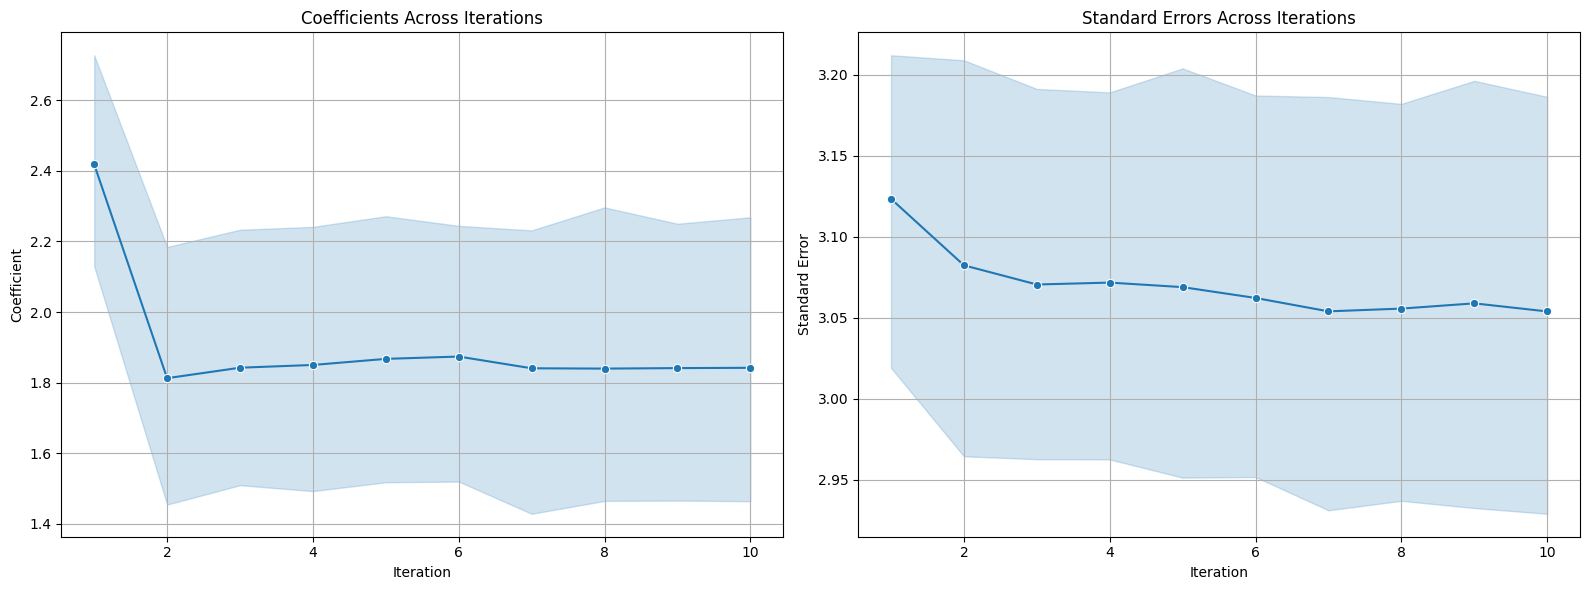

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns


iterations = np.repeat(range(1, max_iterations + 1), n_rep)
repetitions = np.tile(range(1, n_rep + 1), max_iterations)
data = {'Iteration': iterations, 'Repetition': repetitions, 'Coefficient': all_coefs.flatten(), 'SE': all_ses.flatten()}

df = pd.DataFrame(data)

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot for Coefficients
sns.lineplot(x='Iteration', y='Coefficient', data=df, marker='o', ax=axes[0])
axes[0].set_title('Coefficients Across Iterations')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Coefficient')
axes[0].grid(True)

# Plot for Standard Errors
sns.lineplot(x='Iteration', y='SE', data=df, marker='o', ax=axes[1])
axes[1].set_title('Standard Errors Across Iterations')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Standard Error')
axes[1].grid(True)

# Adjust layout to make room for titles and labels
plt.tight_layout()

# Show the plots
plt.show()

## Ensemble Learner

All learners have to support the `sample_weight` in their `fit` method.

In [11]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import StackingRegressor, StackingClassifier, RandomForestClassifier, RandomForestRegressor

reg_estimators = [
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor())
]

class_estimators = [
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier())
]

ml_g = StackingRegressor(
    estimators=reg_estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42)
)

ml_m = StackingClassifier(
    estimators=class_estimators,
    final_estimator=RandomForestClassifier(n_estimators=10,
                                           random_state=42)
)

In [12]:
rdflex_model = RDFlex(dml_data,
                      ml_g,
                      ml_m,
                      fuzzy=fuzzy,
                      n_folds=5,
                      n_rep=1)
rdflex_model.fit(n_iterations=2)

print(rdflex_model)

Method             Coef.     S.E.     t-stat       P>|t|           95% CI
-------------------------------------------------------------------------
Conventional      0.194     1.587     0.122    9.026e-01  [-2.916, 3.304]
Robust                 -        -     -0.014   9.886e-01  [-4.817, 4.748]


## Global / Local Learners

By default, all learners within ``DoubleML.RDFlex`` are local. However, it is easy to make a learner global by the helper functions `GlobalRegressor` and `GlobalClassifier`.

In [13]:
from doubleml.utils import GlobalRegressor, GlobalClassifier

In [14]:
reg_estimators = [
    ('lr local', LinearRegression()),
    ('rf local', RandomForestRegressor()),
    ('lr global', GlobalRegressor(base_estimator=LinearRegression())),
    ('rf global', GlobalRegressor(base_estimator=RandomForestRegressor()))
]

class_estimators = [
    ('lr local', LogisticRegression()),
    ('rf local', RandomForestClassifier()),
    ('lr global', GlobalClassifier(base_estimator=LogisticRegression())),
    ('rf global', GlobalClassifier(base_estimator=RandomForestClassifier()))
]

ml_g = StackingRegressor(
    estimators=reg_estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42)
)

ml_m = StackingClassifier(
    estimators=class_estimators,
    final_estimator=RandomForestClassifier(n_estimators=10,
                                           random_state=42)
)

In [15]:
rdflex_model = RDFlex(dml_data,
                      ml_g,
                      ml_m,
                      fuzzy=fuzzy,
                      n_folds=5,
                      n_rep=1)
rdflex_model.fit(n_iterations=2)

print(rdflex_model)

Method             Coef.     S.E.     t-stat       P>|t|           95% CI
-------------------------------------------------------------------------
Conventional      1.154     1.046     1.103    2.699e-01  [-0.896, 3.205]
Robust                 -        -     1.333    1.825e-01  [-1.000, 5.251]
